## Timm-Classification-CIFAR10-resnet18d-example

In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import CIFAR10

In [3]:
# GPUチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Dataset
- torchvisionのdatasetsにあるCIFAR10をインポート
    - root：画像を一時的にダウンロードする保存先。
    - download：Trueにしたらダウンロードできる。
    - transform：画像を変換する方法。ToTensorにするとpytorchのtensor型になる。
    - train：Trueで学習用データ、Falseで評価用データをダウンロード。

In [4]:
train_data = CIFAR10(
    root="data", download=True, transform=torchvision.transforms.ToTensor(), train=True
)
valid_data = CIFAR10(
    root="data", download=True, transform=torchvision.transforms.ToTensor(), train=False
)

99.4%

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


#### DataLoaderを作成
- batch_size：一度に何枚の画像を取り出すか
- shuffle：データをシャッフルするか

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=256, shuffle=False)

バッチ処理されたデータは”iter”で取り出せます

In [6]:
batch = next(iter(train_loader))
len(batch)

2

出力されるデータは２つあり、１つ目が画像で２つ目が画像のラベルです。
- 画像：128, 3, 32, 32（バッチサイズ, 色, 縦, 横）
- ラベル：128（バッチサイズ）

In [7]:
print(batch[0].shape)
print(batch[1].shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


画像を１枚取り出す
- データはtensor型になっているので、numpyに変換
- 画像を表示するには(縦, 横, 色)の順にする必要があるので、transposeで入れ替え

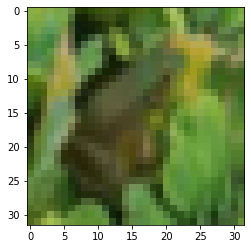

In [8]:
image = batch[0][0]
image = image.numpy().transpose(1, 2, 0)
plt.imshow(image)
plt.show()

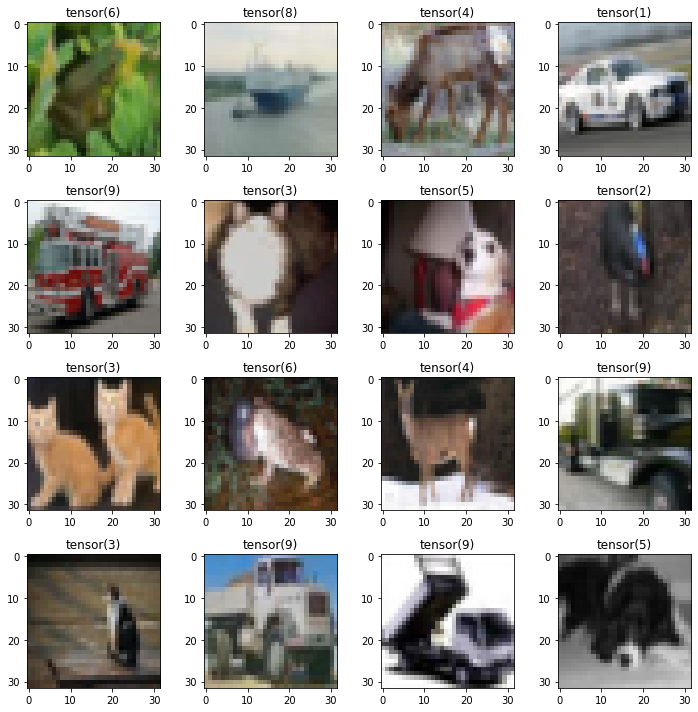

In [9]:
plt.figure(figsize=(10, 10))
for i in range(16):
    image = batch[0][i]
    image = image.numpy().transpose(1, 2, 0)
    label = batch[1][i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(label)
plt.tight_layout()
plt.show()

### モデル構築

timmで使用できるアルゴリズムのリストを出力

In [10]:
from pprint import pprint

pprint(timm.list_models(pretrained=True))

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

#### resnet18dを使用
- `create_model`でアルゴリズム名を渡すとモデルを作成可能
    - pretrained：事前学習をするか。基本True。
    - num_classes：ラベル数。今回は10クラス。

In [11]:
model = timm.create_model("resnet18d", pretrained=True, num_classes=10)

#### 最適化手法, 損失関数の設定

In [12]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

#### モデル学習

In [13]:
history = {"train": [], "valid": []}
for epoch in range(5):
    # 学習--------------------------------------
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        image = batch[0]  # (batch_size, channel, size, size)
        label = batch[1]  # (batch_size)
        preds = model(image)  # (batch_size, num_class)
        loss = criterion(preds, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 評価--------------------------------------
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for batch in valid_loader:
            image = batch[0]  # (batch_size, channel, size, size)
            label = batch[1]  # (batch_size)
            preds = model(image)  # (batch_size, num_class)
            loss = criterion(preds, label)
            valid_loss += loss.item()

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(train_loss)
    print(valid_loss)
    history["train"].append(train_loss)
    history["valid"].append(valid_loss)

0.9242617110614582
0.612098403275013
0.45886154484261027
0.5148574016988278
0.31547791501292793
0.5615133680403233
0.232959717340634
0.5142117194831372
0.17541350123217647
0.5126232646405697


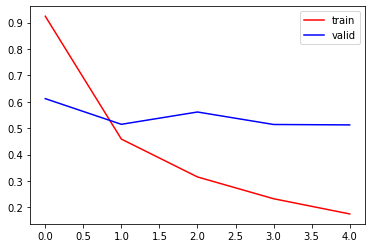

In [14]:
plt.plot(history["train"], "red", label="train")
plt.plot(history["valid"], "blue", label="valid")
plt.legend()
plt.show()

### 予測

In [15]:
model.eval()
OOF = []
labels = []
with torch.no_grad():
    for batch in valid_loader:
        image = batch[0]
        label = batch[1]
        preds = model(image)
        OOF.append(preds.numpy())
        labels.append(label)

In [16]:
OOF = np.concatenate(OOF)
labels = np.concatenate(labels)
print(OOF.shape, labels.shape)

(10000, 10) (10000,)


In [17]:
print(labels[:10])
print("=" * 50)
print(OOF.argmax(axis=1)[:10])

[3 8 8 0 6 6 1 6 3 1]
[3 1 8 0 6 6 1 6 3 1]
